In [50]:
import pandas as pd
import spacy
import gensim
import numpy as np
import string, re
from collections import Counter
import pickle

from tqdm import tqdm
import sklearn
import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import sklearn.neural_network
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalMaxPooling1D, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors, LdaModel
import lucem_illud
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
# if using google colab
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
all_df = pd.read_pickle("D:\\hw\\adopt-proj\\UPDATED_all_df.pkl")

In [45]:
all_adopt_word2vec = gensim.models.Word2Vec.load("D:\\hw\\adopt-proj\\NEW_all_adopt_word2vec.model")

In [9]:
is_labeled = all_df["is_adoptee"] < 2
labeled_df = all_df[is_labeled]
unlabeled_df = all_df[~is_labeled]
labeled_labels = labeled_df.is_adoptee

vocab_size = len(all_df.norm_tokens.explode().unique())
max_length = int(round(all_df.num_tokens.mean(), -2))
embedding_dim = 300

In [5]:
# some comments are very short so we will get rid of those as they are more 
# likely to be noisy
labeled_df = all_df[(all_df.is_adoptee < 2) & (all_df.num_tokens > 25)]
unlabeled_df = all_df[(all_df.is_adoptee == 2) & (all_df.num_tokens > 25)]
print(len(labeled_df))
print(len(unlabeled_df))

39928
181056


### Helpers

In [11]:
def mod_eval(clf, X_test, y_test):
    """
    Given a classifier and data print out a classification report and 
    a corresponding ROC-AUC chart to visualize model performance.

    Inputs:
        clf: an sklearn classifier 
        X_test: an array like structure of model testing features 
        y_test: an array like structure of model testing y's
    Return nothing, prints classification report table and plots a ROC-AUC curve
    """
    # find yhats for testing data
    y_pred_test = clf.predict(X_test)
    # model performance on testing set
    print(classification_report(y_test, y_pred_test),"\n")
    
    con_mat = confusion_matrix(y_test, y_pred_test)
    # help displaying a confusion matrix with labels
    # https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
    labels = ['Non-adoptees', 'Adoptees']
    cmd = ConfusionMatrixDisplay(con_mat, display_labels=labels)
    cmd.plot(cmap="crest")

In [24]:
def vect_and_split(vectorizer, feature_col, y_col):
    """
    Vectorizers a column of text data features, and performs a test-train split
    Inputs:
        vectorizer: the vectorizer to vectorize the feature column
        feature_col: the column of textual data that will act as the features
        y_col: the column containing the y's
    Outputs:
        train and test split for X and y's
    """

    # convert the cleaned reviews to vectors
    X = vectorizer.fit_transform(feature_col)
    X_dense = X.toarray()
    return train_test_split(X_dense, y_col, test_size=0.2, shuffle=True, random_state=42)

In [38]:
X = labeled_df.norm_tokens.apply(lambda x: " ".join(x))

In [53]:
adopt_tfidf_vect = TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
X_train, X_test, y_train, y_test = vect_and_split(adopt_tfidf_vect, X, labeled_df['is_adoptee'])

## Sentiment Analysis

In [43]:
tqdm().pandas()
sentiments = X.progress_apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x))

0it [00:00, ?it/s]


100%|██████████| 53325/53325 [06:03<00:00, 146.54it/s]


## MLP Classifier

In [27]:
clf_MLP = sklearn.neural_network.MLPClassifier(random_state=42)
clf_MLP.fit(X_train, y_train)

MLPClassifier(random_state=42)

In [29]:
pickle.dump(clf_MLP, open("clf_MLP.pkl", "wb"))

# load back in 
# clf_MLP = pickle.load(open("D:\\hw\\adopt-proj\\clf_MLP.pkl", "rb"))


              precision    recall  f1-score   support

           0       0.66      0.56      0.60      4235
           1       0.74      0.81      0.77      6430

    accuracy                           0.71     10665
   macro avg       0.70      0.68      0.69     10665
weighted avg       0.70      0.71      0.70     10665
 



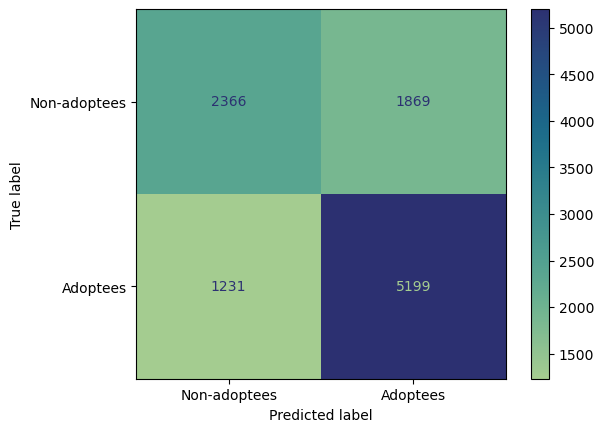

In [33]:
mod_eval(clf_MLP, X_test, y_test)

## Recurrent Neural Network

In [118]:
vocab_size = X_train.shape[1]
embedding_dim = 250
max_sequence_length = labeled_df.num_tokens.max()
nodes = 64

In [119]:
model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    tensorflow.keras.layers.SimpleRNN(units=nodes, activation='relu'),
    tensorflow.keras.layers.Dense(1, activation='sigmoid')]) # 1 for binary classification


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', "precision", "recall", "auc"])

In [128]:
# train model
training_model = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

MemoryError: Unable to allocate 3.93 GiB for an array with shape (42660, 12360) and data type float64